 # Rookie's Guide to Building a Mini-GPT

 Hey there! So, you want to build a language model from scratch? Awesome! This is, in my opinion, the *best* way to learn what's actually going on inside models like GPT. We're going to build a **Small Language Model (SLM)**, aiming for about 40-50 million parameters. It's tiny compared to the giants, but it's *ours*, and we'll understand every single line of it.

Our goal is to train this model on "TinyStories," a dataset of short stories for kids, and teach it to generate its own creative little stories.

![arch](https://file.notion.so/f/f/cc2e367d-8a55-498e-a069-135390335a78/136da529-4cdf-4045-a457-4e9a35e887dc/SLM_Architecture.webp?table=block&id=29bd5368-c6db-8014-9140-f79b1686e939&spaceId=cc2e367d-8a55-498e-a069-135390335a78&expirationTimestamp=1761748626445&signature=ZhDJny5MpXPBCJgfcJc0D3w5L5uMZNWaN5GffRZwVjE&downloadName=SLM_Architecture.webp)



Before we write a single line of code, what's the strategy? We can't just jump in blind. Here's the high-level plan I've sketched out:

1. **Get Data**: We need a ton of text. But not just any text, we need something simple and clean for our small model to learn from. The **TinyStories** dataset is perfect. It's millions of simple stories written for 3-4 year olds.

2. **Process the Data**: Models don't read words. They read numbers (tokens). We'll use a standard tokenizer (GPT-2's) to convert all that text into long sequences of numbers.

3. **"Bin" the Data** : We can't load all that data into RAM. We'll tokenize everything and save it to disk in binary files (``train.bin, validation.bin``). This is a pro-move I learned from Andrej Karpathy's nanoGPT. It lets us grab chunks of data from disk super-fast during training without eating all our memory.

4. **Define the Model**: This is the fun part! We'll build the "Transformer" architecture from the ground up, layer by layer, using pure PyTorch. We'll need:

    - An Embedding layer (for tokens and positions).

    - Transformer "Blocks" (which contain Self-Attention and a small "thinking" network).

    - A final "head" layer to predict the next word.

5. **Write the Training Loop**: No Trainer.train() for us. We'll write our own loop. This means manually:

    - Getting a batch of data.

    - Doing the forward pass (running data through the model).

    - Calculating the loss (how "wrong" the model was).

    - Doing the backward pass (calculating gradients).

    - Updating the model's weights (the "learning" part).

6. **Train!** : We'll run this loop for thousands of steps, check our validation loss, save the best-performing model, and plot the loss to see if it's actually learning.

7. **Test It**: Once it's trained, we'll give it a prompt and see what kind of story it writes!


## Setting Up Our Environment

First things first, we need to install our tools. This is like going to the hardware store before we start building.

- `transformers`, `datasets`, `accelerate`: These are from Hugging Face. We need `datasets` to easily download our 'TinyStories' and `transformers`... well, we're mostly building our own, but we'll see! `accelerate` helps with efficient training.
- `tiktoken`: This is our "dictionary" or "tokenizer." It's the official one OpenAI uses for GPT-2, and it will turn our English stories into lists of numbers (tokens) that the computer can understand.

In [1]:
# Install required libraries
!pip install transformers datasets accelerate

In [10]:
!pip install datasets
!pip install -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.8/506.8 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 19.4 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.


Now, let's import the load_dataset function from our newly installed library and grab the stories. This one line downloads the entire `"roneneldan/TinyStories"` dataset. It's that easy.

In [1]:
from datasets import load_dataset

ds = load_dataset("roneneldan/TinyStories")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00004-2d5a1467fff108(…):   0%|          | 0.00/249M [00:00<?, ?B/s]

data/train-00001-of-00004-5852b56a2bd28f(…):   0%|          | 0.00/248M [00:00<?, ?B/s]

data/train-00002-of-00004-a26307300439e9(…):   0%|          | 0.00/246M [00:00<?, ?B/s]

data/train-00003-of-00004-d243063613e5a0(…):   0%|          | 0.00/248M [00:00<?, ?B/s]

data/validation-00000-of-00001-869c898b5(…):   0%|          | 0.00/9.99M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2119719 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/21990 [00:00<?, ? examples/s]

Next, we'll import all the tools we need for tokenization and data processing.

- `tiktoken`: The library we just installed.
- `os`: A built-in Python library for checking if files (like our tokenized data) already exist.
- `numpy as np`: A super-popular library for fast math and, in our case, for a clever memory-saving trick.
- `tqdm.auto as tqdm`: This is a wonderful little tool that just draws a progress bar for our loops. It's not essential, but it's *so* nice to know how long things are going to take.

## From Stories to Numbers (Tokenization)

After Importing, the very next step would be, changing the text into numbers which is called `"Tokenization"`

Computers don't read words. They read numbers. Our "tokenizer" is the translator. We're using the "gpt2" dictionary, which has a vocabulary of 50,257 unique "tokens." A token can be a full word (`" the"`), a part of a word (`"ing"`), or even just punctuation.

`enc.encode_ordinary` is the function that does the translation: `"Hello world"` -> `[15496, 995]`.

```
enc = tiktoken.get_encoding("gpt2")
```
We'll define a simple function `process` that takes one story (`example`) and returns a dictionary containing the list of token `ids` and the `len`gth of that list.

```
# Some functions from [https://github.com/karpathy/nanoGPT/blob/master/data/openwebtext/prepare.py](https://github.com/karpathy/nanoGPT/blob/master/data/openwebtext/prepare.py)

def process(example):
    ids = enc.encode_ordinary(example['text']) # encode_ordinary ignores any special tokens
    out = {'ids': ids, 'len': len(ids)}
    return out
```

This next block is the beefiest part of our data prep. The TinyStories dataset is really *huge* (billions of tokens!). We can't just load it all into RAM directly.

So, here's our plan:

1. **`if not os.path.exists("train.bin")`**: We'll check if we've already done this work. If the `train.bin` file exists, we skip this whole mess.
2. **`tokenized = ds.map(...)`**: This is a super-fast way to run our `process` function on *every single story* in the dataset. We use `num_proc=8` to do it in parallel.
3. **`for split, dset in tokenized.items()`**: We'll loop through our 'train' and 'validation' splits.
4. **`arr = np.memmap(...)`**: This is the magic trick. `memmap` stands for "memory map." It creates a *giant, empty file* on our hard drive (`train.bin` or `validation.bin`) and pretends it's an array in RAM. We can write to this "array," and `numpy` will handle saving it to the disk. This way, we *never* hold the whole dataset in memory.
5. **The inner loop (`for batch_idx...`)**: We then loop through the tokenized dataset in chunks, `concatenate` the token IDs into a batch, and write that batch into our `memmap` array.
6. **`arr.flush()`**: This just tells the `memmap` to make sure everything is *really* saved to the disk.

When this is done, we'll have two files, `train.bin` and `validation.bin`, that contain *all* the tokenized stories, one after another, in a single massive list of numbers.

In [2]:
!pip install tiktoken
import tiktoken
import os
import numpy as np
from tqdm.auto import tqdm

enc = tiktoken.get_encoding("gpt2")

# Some functions from https://github.com/karpathy/nanoGPT/blob/master/data/openwebtext/prepare.py

def process(example):
    ids = enc.encode_ordinary(example['text']) # encode_ordinary ignores any special tokens
    out = {'ids': ids, 'len': len(ids)}
    return out

if not os.path.exists("train.bin"):
    print("train.bin not found, tokenizing and building bin files...")
    tokenized = ds.map(
        process,
        remove_columns=['text'],
        desc="tokenizing the splits",
        num_proc=8,
        )
    # concatenate all the ids in each dataset into one large file we can use for training
    for split, dset in tokenized.items():
        arr_len = np.sum(dset['len'], dtype=np.uint64)
        filename = f'{split}.bin'
        dtype = np.uint16 # (can do since enc.max_token_value == 50256 is < 2**16)
        arr = np.memmap(filename, dtype=dtype, mode='w+', shape=(arr_len,))
        total_batches = 1024

        idx = 0
        for batch_idx in tqdm(range(total_batches), desc=f'writing {filename}'):
            # Batch together samples for faster write
            batch = dset.shard(num_shards=total_batches, index=batch_idx, contiguous=True).with_format('numpy')
            arr_batch = np.concatenate(batch['ids'])
            # Write into mmap
            arr[idx : idx + len(arr_batch)] = arr_batch
            idx += len(arr_batch)
        arr.flush()
    print("Tokenization and .bin file creation complete.")
else:
    print("train.bin found, skipping tokenization.")

train.bin not found, tokenizing and building bin files...


tokenizing the splits (num_proc=8):   0%|          | 0/2119719 [00:00<?, ? examples/s]

tokenizing the splits (num_proc=8):   0%|          | 0/21990 [00:00<?, ? examples/s]

writing train.bin:   0%|          | 0/1024 [00:00<?, ?it/s]

writing validation.bin:   0%|          | 0/1024 [00:00<?, ?it/s]

Tokenization and .bin file creation complete.


## Creating Batches

How do we teach a language model? We make it **predict the next word.**

This `get_batch` function is our "teacher." It creates the lesson plans (batches) for our model.

1. **`import torch`**: We need PyTorch, our main deep learning library.
2. **Set some configs**:
    - `batch_size = 32`: We'll give the model 32 examples to learn from at once.
    - `block_size = 128`: This is our "context window" or "attention span." The model will look at 128 tokens at a time.
    - `device = "cuda"`: We're telling PyTorch to use the GPU, which is *way* faster for this stuff.
3. **`def get_batch(split)`**:
    - `data = np.memmap(...)`: We re-open our giant `.bin` file (in 'r'ead-only mode).
    - `ix = torch.randint(...)`: We pick 32 (`batch_size`) random starting points in the file.
    - **This is the core concept:**
        - `x = ...`: For each random starting point `i`, we grab the tokens from `i` to `i+block_size`. This is our **input**.
        - `y = ...`: We grab the tokens from `i+1` to `i+1+block_size`. This is our **target**.
    - Think about it:
        - `x` is: `["Once", "upon", "a", "time"]`
        - `y` is: `["upon", "a", "time", "."]`
    - We're teaching the model: "When you see 'Once', predict 'upon'." "When you see 'Once upon', predict 'a'." And so on.
    - `x, y = x.pin_memory()...`: This is an optimization. It locks the data in a special place in RAM so it can be moved to the GPU *super* fast.

In [3]:
import torch # Make sure torch is imported for get_batch

# Training Config (needed for get_batch)
batch_size = 32
block_size = 128
device = "cuda" if torch.cuda.is_available() else "cpu"
device_type = 'cuda' if 'cuda' in device else 'cpu'

# Some functions from https://github.com/karpathy/nanoGPT/blob/master/train.py with slight modifications
#block size = context window
def get_batch(split):
    # We recreate np.memmap every batch to avoid a memory leak, as per
    # https://stackoverflow.com/questions/45132940/numpy-memmap-memory-usage-want-to-iterate-once/61472122#61472122
    if split == 'train':
        data = np.memmap('train.bin', dtype=np.uint16, mode='r')
    else:
        # Note: The original dataset calls it 'validation', so we use 'validation.bin'
        data = np.memmap('validation.bin', dtype=np.uint16, mode='r')
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
    if device_type == 'cuda':
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y

## Configuring the Transformer Architecture

This is the most exciting part. We're building the model. First, our imports:

- `torch.nn as nn`: This is the heart of PyTorch, containing all the "Lego blocks" for neural networks (like `nn.Linear`, `nn.Embedding`).
- `torch.nn.functional as F`: This contains useful *functions* (like `softmax`, `cross_entropy`).
- `math`: For a square root.
- `dataclass`: A nice way to create a "config" object.
- `nullcontext`: A helper for turning "on" or "off" code sections.

Let's think of this as our famous gaming lego blocks.

### Lego Block 1: `LayerNorm`

This is our "principal" module. Neural networks work best when the numbers flowing through them are "normalized" (i.e., not too big or too small). A `LayerNorm` cleans up the data at each step, making training much more stable.

```
class LayerNorm(nn.Module):
    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None
    def forward(self, x):
        return F.layer_norm(x, self.weight.shape, self.weight, self.bias, 1e-5)
```

### Lego Block 2: `CausalSelfAttention`

This is the *magic* of the Transformer. It's how tokens "talk" to each other.

1. **`__init__`**:
    - `self.c_attn = nn.Linear(...)`: This *one* linear layer creates our **Query, Key, and Value** vectors all at once. It's a classic optimization.
    - `self.c_proj = nn.Linear(...)`: This is the "output" layer, after attention is done.
    - `self.n_head`: We're using **Multi-Head Attention**. Instead of having one "attention" mechanism, we'll have `n_head` (e.g., 6) of them working in parallel. It's like having 6 people read a sentence, each looking for different things.
    - `self.flash = ...`: This checks if your GPU supports "Flash Attention," a super-fast, memory-efficient version.
    - `if not self.flash:`: If we *don't* have Flash Attention, we have to create the "causal mask" manually. This is a triangle-shaped mask that **prevents tokens from "seeing" into the future**. When predicting the 5th word, the model can only look at words 1-4. This is what makes it "causal."
2. **`forward(self, x)`**:
    - `q, k, v = self.c_attn(x).split(...)`: We run our input `x` through the linear layer and split the result into our Query, Key, and Value.
    - `k = k.view(...)`, `q = q.view(...)`, `v = v.view(...)`: We reshape these vectors to prepare them for multi-head attention.
    - `if self.flash:`: We just call the optimized function. Easy!
    - `else:`: We do the classic "Attention is All You Need" math:
        - `att = (q @ k.transpose(-2, -1))`: We find the "similarity" between all queries and keys.
        - `att = att.masked_fill(...)`: We apply our "no-cheating" mask.
        - `att = F.softmax(att, ...)`: We normalize the scores.
        - `y = att @ v`: We create our output by weighting the values (`v`) based on the attention scores (`att`).
    - `y = y.transpose...`: We stitch the heads back together.
    - `y = self.resid_dropout(self.c_proj(y))`: We run it through the final output layer and apply dropout (a regularization trick).

```
    class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.flash = hasattr(F, 'scaled_dot_product_attention')
        if not self.flash:
            print("Warning: Flash Attention not available. Using manual causal mask.")
            self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                          .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size()
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)

        if self.flash:
            y = F.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.attn_dropout.p if self.training else 0.0, is_causal=True)
        else:
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v

        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_dropout(self.c_proj(y))
        return y
```

### Lego Block 3: `MLP`

This is the "thinking" part. After all the tokens have "talked" to each other in the Attention block, each token goes *individually* through this `MLP` (Multi-Layer Perceptron) to "think" about what it just learned. It's just two linear layers with a GELU activation function in between.

```
class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu = nn.GELU()
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)
    def forward(self, x):
        return self.dropout(self.c_proj(self.gelu(self.c_fc(x))))
```

### Lego Block 4: `Block`

Now we just put our pieces together! A Transformer `Block` is:

1. A "principal" (`ln1`)
2. The "talking" part (`attn`)
3. Another "principal" (`ln2`)
4. The "thinking" part (`mlp`)

Crucially, we have "residual connections" (`x = x + ...`). This means we add the *input* of the layer to its *output*. This is a *vital* trick that helps the "do better" instructions (gradients) flow backward during training and prevents the model from "forgetting" what it knew.

```

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln1 = LayerNorm(config.n_embd, config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln2 = LayerNorm(config.n_embd, config.bias)
        self.mlp = MLP(config)
    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

```

### The Blueprint: `GPTConfig`

A `dataclass` is just a simple way to create a "struct" or "blueprint" object. This will hold all our model's hyperparameters, like how many layers, how many heads, etc.

```
@dataclass
class GPTConfig:
    block_size: int
    vocab_size: int
    n_layer: int
    n_head: int
    n_embd: int
    dropout: float = 0.0
    bias: bool = True
```

### Putting It All Together: The `GPT` Model

This is our final model!

1. **`__init__`**:
    - We create a `transformer` as an `nn.ModuleDict`.
    - `wte = nn.Embedding(...)`: This is our "token embedding" layer. It turns token IDs (like `5023`) into dense vectors (our `n_embd` size).
    - `wpe = nn.Embedding(...)`: This is our "positional embedding" layer. It creates a learned vector for each *position* (0, 1, 2... up to `block_size`).
    - `h = nn.ModuleList(...)`: This is where we create our stack of `Block`s. We just loop `n_layer` times and create that many blocks.
    - `ln_f = LayerNorm(...)`: A final "janitor" at the very end.
    - `lm_head = nn.Linear(...)`: This is the **most important** layer. After all the processing, the final token vectors go here. This layer's job is to output a score for *every single word in our vocabulary* (all 50,257 of them).
    - `self.transformer.wte.weight = self.lm_head.weight`: This is a clever trick called "weight tying." We force the "dictionary" that turns tokens into vectors (`wte`) to be the *same* as the one that turns vectors back into word-scores (`lm_head`). This saves millions of parameters!
2. **`_init_weights`**: We initialize our weights with a specific "normal" distribution. This helps training start off smoothly.
3. **`forward`**: This is the data's journey.
    - `tok_emb = self.transformer.wte(idx)`: Get the token vectors.
    - `pos_emb = self.transformer.wpe(pos)`: Get the position vectors.
    - `x = self.transformer.drop(tok_emb + pos_emb)`: **Add them together!** This is how the model knows *what* word is *where*.
    - `for block in self.transformer.h: x = block(x)`: Send the data through all our `Block`s, one by one.
    - `x = self.transformer.ln_f(x)`: Final cleanup.
    - `if targets is not None:`: If we're **training**, we calculate the `logits` (the final scores) and the `loss` (our "grade") and return both.
    - `else:`: If we're **generating** (doing inference), we *only* care about the scores for the very last token. We return just those.
4. **`generate`**: This is our "story writer" function.
    - `@torch.no_grad()`: We're not training, so we tell PyTorch not to save any gradient info. This saves a *ton* of memory.
    - We loop `max_new_tokens` times.
    - `idx_cond = ...`: We make sure our "context" (`idx`) is never longer than our model's `block_size`.
    - `logits, _ = self(idx_cond)`: We get the model's predictions for the *next* word.
    - `logits = logits[:, -1, :] / temperature`: We apply "temperature." A lower temp makes the model more confident and repetitive; a higher temp makes it more creative and random.
    - `if top_k is not None:`: We use "top-k" sampling. We only consider the `k` most-likely words, which helps prevent the model from picking really weird, low-probability tokens.
    - `probs = F.softmax(logits, ...)`: We turn the scores into probabilities (e.g., "a": 70%, "the": 20%, ...).
    - `idx_next = torch.multinomial(probs, ...)`: We *sample* from this probability distribution. This is *not* just picking the highest one (that's "greedy" search). This is what makes the text feel creative.
    - `idx = torch.cat((idx, idx_next), ...)`: We add our newly predicted word to our context, and...
    - ...the loop repeats! The new word is now part of the context for predicting the *next* word.

### Now we just plug in our blueprint!

- `vocab_size=50257`: From our GPT-2 tokenizer.
- `block_size=128`: Our 128-token attention span.
- `n_layer=6`: 6 `Block`s stacked on top of each other.
- `n_head=6`: 6 attention heads.
- `n_embd=384`: Each token will be represented by a vector of 384 numbers.

And... we build it! The print statement will tell us how many parameters our model has. With this config, it's about **30 million**. A perfect SLM!

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import math
from dataclasses import dataclass
from contextlib import nullcontext

class LayerNorm(nn.Module):
    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None
    def forward(self, x):
        return F.layer_norm(x, self.weight.shape, self.weight, self.bias, 1e-5)

class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.flash = hasattr(F, 'scaled_dot_product_attention')
        if not self.flash:
            print("Warning: Flash Attention not available. Using manual causal mask.")
            self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                          .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size()
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)

        if self.flash:
            y = F.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.attn_dropout.p if self.training else 0.0, is_causal=True)
        else:
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v

        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_dropout(self.c_proj(y))
        return y

class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu = nn.GELU()
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)
    def forward(self, x):
        return self.dropout(self.c_proj(self.gelu(self.c_fc(x))))

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln1 = LayerNorm(config.n_embd, config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln2 = LayerNorm(config.n_embd, config.bias)
        self.mlp = MLP(config)
    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

@dataclass
class GPTConfig:
    block_size: int
    vocab_size: int
    n_layer: int
    n_head: int
    n_embd: int
    dropout: float = 0.0
    bias: bool = True

class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.transformer = nn.ModuleDict(dict(
            wte=nn.Embedding(config.vocab_size, config.n_embd),
            wpe=nn.Embedding(config.block_size, config.n_embd),
            drop=nn.Dropout(config.dropout),
            h=nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f=LayerNorm(config.n_embd, config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.transformer.wte.weight = self.lm_head.weight  # weight tying

        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                nn.init.normal_(p, mean=0.0, std=0.02 / math.sqrt(2 * config.n_layer))

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device)

        tok_emb = self.transformer.wte(idx)
        pos_emb = self.transformer.wpe(pos)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
            return logits, loss
        else:
            logits = self.lm_head(x[:, [-1], :])
            return logits, None

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Generate tokens given a conditioning sequence.
        idx: Tensor of shape (B, T)
        """
        for _ in range(max_new_tokens):
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx


# Model Config
config = GPTConfig(
    vocab_size=50257,    # use the tokenizer's vocab size (GPT-2)
    block_size=128,      # context size
    n_layer=6,
    n_head=6,
    n_embd=384,
    dropout=0.1,
    bias=True
)

model = GPT(config)
print(f"Model created with {sum(p.numel() for p in model.parameters())/1e6:.2f}M parameters.")

Model created with 30.00M parameters.


## The Report Card (Loss Function)

This function, `estimate_loss`, is our "report card" generator. During training, we need to pause and see how we're doing.

- `@torch.no_grad()`: We're just checking our work, not learning, so we turn off gradients.
- `model.eval()`: We put the model in "evaluation" mode (this turns off dropout, etc.).
- We loop `eval_iters` times (500) for both 'train' and 'validation' data.
- We get a batch, calculate the loss, and average it all up.
- `model.train()`: We MUST remember to put the model *back* in "training" mode!

This function will tell us our "Training Loss" (how well we're doing on data we've seen) and our "Validation Loss" (how well we're doing on *new*, unseen data). The validation loss is the most important one.

```
# Training Config (needed for estimate_loss)
eval_iters = 500
# dtype and ctx are defined in Step 6, but we need a placeholder here if running cells out of order
# We will define them properly in the next step.
# For now, just define ctx for estimate_loss
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=torch.float16) # default to float16

@torch.no_grad() # decorator for estimate_loss
def estimate_loss(model):
    out = {}
    model.eval()
    # Note: original code used 'val', but dataset split is 'validation'
    for split in ['train', 'validation']:
        losses = torch.zeros(eval_iters)
        for k in tqdm(range(eval_iters), desc=f"Estimating {split} loss"):
            # Use 'validation' for get_batch if split is 'validation'
            batch_split = 'val' if split == 'validation' else 'train'
            X, Y = get_batch(batch_split)
            with ctx:
                logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

```




In [5]:
# Training Config (needed for estimate_loss)
eval_iters = 500
# dtype and ctx are defined in Step 6, but we need a placeholder here if running cells out of order
# We will define them properly in the next step.
# For now, just define ctx for estimate_loss
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=torch.float16) # default to float16


@torch.no_grad() # decorator for estimate_loss
def estimate_loss(model):
    out = {}
    model.eval()
    # Note: original code used 'val', but dataset split is 'validation'
    for split in ['train', 'validation']:
        losses = torch.zeros(eval_iters)
        for k in tqdm(range(eval_iters), desc=f"Estimating {split} loss"):
            # Use 'validation' for get_batch if split is 'validation'
            batch_split = 'val' if split == 'validation' else 'train'
            X, Y = get_batch(batch_split)
            with ctx:
                logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

## The Training "Engine" (Config & Optimizer)

Here we define all our training hyperparameters.

- **`learning_rate`**: How big of a "step" the model takes when it learns.
- **`max_iters`**: We'll run 20,000 training steps (lessons).
- **`warmup_steps` & `min_lr`**: We'll use a "learning rate scheduler." We'll *start* with a tiny learning rate, "warm up" to our max `learning_rate` over 1000 steps, and then slowly "cool down" to `min_lr` for the rest of training. This is a crucial stability trick.
- **`gradient_accumulation_steps`**: This is a "pro gamer move" for small GPUs. We can't fit a giant batch in memory. So, we'll "pretend" to have a giant batch of `32*32=1024` by running 32 small batches, *accumulating* their "do better" instructions (gradients), and *then* updating the model all at once.
- **`dtype = 'bfloat16'`**: This is "mixed precision." We'll do our math with "half-precision" numbers (`bfloat16` or `float16`) instead of full `float32`. This is *dramatically* faster and saves a ton of VRAM.
- **`ctx = ...autocast(...)`**: This is the context manager that *enables* mixed precision.

In [6]:
# Training Config
learning_rate = 1e-4 #more stable training, earlier 1e-4
max_iters = 20000 #increase from 25000
warmup_steps = 1000 #smoother initial train, earlier 100
min_lr = 5e-4 #lower rate, earlier 5e-4
# eval_iters = 500 # already defined
# batch_size = 32 # already defined
# block_size = 128 # already defined

gradient_accumulation_steps = 32 # reduced from 50

# device and device_type are already defined in Step 3
# note: float16 data type will automatically use a GradScaler

# How to use autocast https://wandb.ai/wandb_fc/tips/reports/How-To-Use-Autocast-in-PyTorch--VmlldzoyMTk4NTky
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]

# Redefine ctx with the correct ptdtype
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

torch.set_default_device(device)
torch.manual_seed(42)

print(f"Using device: {device}")
print(f"Using dtype: {dtype}")

Using device: cuda
Using dtype: bfloat16


Now we build our "engine."

- **`optimizer = torch.optim.AdamW(...)`**: We're using the AdamW optimizer. It's an advanced "engine" that takes our loss and calculates how to update all 45 million parameters. We also add `weight_decay`, a regularization trick to prevent overfitting.
- **`scheduler_warmup`, `scheduler_decay`, `scheduler`**: This is where we define our "warmup and cool down" plan using the `LinearLR` and `CosineAnnealingLR` schedulers.
- **`scaler = torch.cuda.amp.GradScaler(...)`**: This is the *helper* for mixed precision. Because we're using `float16`, numbers can sometimes get *too* small ("underflow"). The `GradScaler` scales all our numbers *up* before the "backward" step and then scales them *down* again for the update, preventing this problem.

In [7]:
from torch.optim.lr_scheduler import LinearLR,SequentialLR, CosineAnnealingLR

##PUT IN WEIGHT DECAY, CHANGED BETA2 to 0.95
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.95), weight_decay=0.1, eps=1e-9) #weight decay for regularization

scheduler_warmup = LinearLR(optimizer, start_factor=0.01, total_iters = warmup_steps) #Implement linear warmup
scheduler_decay = CosineAnnealingLR(optimizer,T_max = max_iters - warmup_steps, eta_min = min_lr) #Implement lr decay
scheduler = SequentialLR(optimizer, schedulers=[scheduler_warmup, scheduler_decay], milestones=[warmup_steps]) #Switching from warmup to decay

# https://stackoverflow.com/questions/72534859/is-gradscaler-necessary-with-mixed-precision-training-with-pytorch
scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))

/tmp/ipython-input-1451386750.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))


## Let's Train! (The Training Loop)

This is it. The main event.

1. We set up some tracking variables (`best_val_loss`, our loss lists) and move our model to the GPU.
2. We start our main `pbar` (progress bar) loop for `max_iters`.
3. **Inside the loop:**
    - **"Report Card" Time (`if epoch % eval_iters == 0`)**: Every 500 steps, we pause, call `estimate_loss`, and print our progress.
    - **Save Checkpoint (`if losses['validation'] < best_val_loss`)**: If this is the *best* validation loss we've ever seen, we save the model's parameters (`state_dict`) to `best_model_params.pt`.
    - **Get Lesson (`X, y = get_batch("train")`)**: We get a new batch of data.
    - **Forward Pass (`with ctx: ... loss = ...`)**: We run the data through the model, get the `logits` and `loss`. We also divide the loss by `gradient_accumulation_steps` to keep our average correct.
    - **Backward Pass (`scaler.scale(loss).backward()`)**: This is the "learning" part. PyTorch calculates the "do better" instructions (gradients) for all 45M parameters. The `scaler` scales the loss first.
    - **Accumulation Check (`if ((epoch + 1) % ...`)**: We only update our model *after* 32 steps.
        - `torch.nn.utils.clip_grad_norm_`: We "clip" the gradients to prevent them from "exploding" (getting too big), which is another stability trick.
        - `scaler.step(optimizer)`: The `scaler` tells the optimizer to update the model, *after* un-scaling the gradients.
        - `scaler.update()`: The `scaler` updates itself for the next round.
        - `optimizer.zero_grad()`: We **must** clear the old gradients, or they'll just keep adding up.
    - **`scheduler.step()`**: We nudge our learning rate according to our "warmup/cool down" plan.

And that's it! We just... wait.

In [8]:
best_val_loss = float('inf')
best_model_params_path = "best_model_params.pt"
train_loss_list, validation_loss_list = [], []

# Ensure model is on the correct device
model = model.to(device)

print("Starting training...")
# In your training loop
pbar = tqdm(range(max_iters))
for epoch in pbar:
    if epoch % eval_iters == 0 and epoch != 0:
        # Ensure estimate_loss uses the correct device
        losses = estimate_loss(model)
        # Note: The split name is 'validation'
        print(f"\nEpoch {epoch}: train loss {losses['train']:.4f}, val loss {losses['validation']:.4f}")
        print(f"The current learning rate: {optimizer.param_groups[0]['lr']:.6f}")
        train_loss_list += [losses['train']]
        validation_loss_list += [losses['validation']]

        if losses['validation'] < best_val_loss:
            best_val_loss = losses['validation']
            torch.save(model.state_dict(), best_model_params_path)
            print(f"Saved new best model to {best_model_params_path}")

    # Ensure X and y are on the correct device
    X, y = get_batch("train")
    # X, y = X.to(device), y.to(device) # get_batch already moves to device

    with ctx:
        logits, loss = model(X, y)
        loss = loss / gradient_accumulation_steps

    scaler.scale(loss).backward()

    if ((epoch + 1) % gradient_accumulation_steps == 0) or (epoch + 1 == max_iters):
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        # Optimizer step
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)

    # Update learning rate
    scheduler.step()

    # Update progress bar
    pbar.set_description(f"Iter {epoch}: loss {loss.item() * gradient_accumulation_steps:.4f}")


print("Training finished.")

Starting training...


  0%|          | 0/20000 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Estimating train loss:   0%|          | 0/500 [00:00<?, ?it/s]

Estimating validation loss:   0%|          | 0/500 [00:00<?, ?it/s]


Epoch 500: train loss 9.7840, val loss 9.7867
The current learning rate: 0.000050
Saved new best model to best_model_params.pt


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Estimating train loss:   0%|          | 0/500 [00:00<?, ?it/s]

Estimating validation loss:   0%|          | 0/500 [00:00<?, ?it/s]


Epoch 1000: train loss 8.8665, val loss 8.8709
The current learning rate: 0.000100
Saved new best model to best_model_params.pt


Estimating train loss:   0%|          | 0/500 [00:00<?, ?it/s]

Estimating validation loss:   0%|          | 0/500 [00:00<?, ?it/s]


Epoch 1500: train loss 7.8602, val loss 7.8583
The current learning rate: 0.000101
Saved new best model to best_model_params.pt


Estimating train loss:   0%|          | 0/500 [00:00<?, ?it/s]

Estimating validation loss:   0%|          | 0/500 [00:00<?, ?it/s]


Epoch 2000: train loss 6.9430, val loss 6.9394
The current learning rate: 0.000103
Saved new best model to best_model_params.pt


Estimating train loss:   0%|          | 0/500 [00:00<?, ?it/s]

Estimating validation loss:   0%|          | 0/500 [00:00<?, ?it/s]


Epoch 2500: train loss 6.1957, val loss 6.1890
The current learning rate: 0.000106
Saved new best model to best_model_params.pt


Estimating train loss:   0%|          | 0/500 [00:00<?, ?it/s]

Estimating validation loss:   0%|          | 0/500 [00:00<?, ?it/s]


Epoch 3000: train loss 5.6395, val loss 5.6345
The current learning rate: 0.000111
Saved new best model to best_model_params.pt


Estimating train loss:   0%|          | 0/500 [00:00<?, ?it/s]

Estimating validation loss:   0%|          | 0/500 [00:00<?, ?it/s]


Epoch 3500: train loss 5.1712, val loss 5.1693
The current learning rate: 0.000117
Saved new best model to best_model_params.pt


Estimating train loss:   0%|          | 0/500 [00:00<?, ?it/s]

Estimating validation loss:   0%|          | 0/500 [00:00<?, ?it/s]


Epoch 4000: train loss 4.8167, val loss 4.8154
The current learning rate: 0.000124
Saved new best model to best_model_params.pt


Estimating train loss:   0%|          | 0/500 [00:00<?, ?it/s]

Estimating validation loss:   0%|          | 0/500 [00:00<?, ?it/s]


Epoch 4500: train loss 4.5545, val loss 4.5573
The current learning rate: 0.000133
Saved new best model to best_model_params.pt


Estimating train loss:   0%|          | 0/500 [00:00<?, ?it/s]

Estimating validation loss:   0%|          | 0/500 [00:00<?, ?it/s]


Epoch 5000: train loss 4.3367, val loss 4.3412
The current learning rate: 0.000142
Saved new best model to best_model_params.pt


Estimating train loss:   0%|          | 0/500 [00:00<?, ?it/s]

Estimating validation loss:   0%|          | 0/500 [00:00<?, ?it/s]


Epoch 5500: train loss 4.1618, val loss 4.1608
The current learning rate: 0.000153
Saved new best model to best_model_params.pt


Estimating train loss:   0%|          | 0/500 [00:00<?, ?it/s]

Estimating validation loss:   0%|          | 0/500 [00:00<?, ?it/s]


Epoch 6000: train loss 4.0042, val loss 4.0013
The current learning rate: 0.000165
Saved new best model to best_model_params.pt


Estimating train loss:   0%|          | 0/500 [00:00<?, ?it/s]

Estimating validation loss:   0%|          | 0/500 [00:00<?, ?it/s]


Epoch 6500: train loss 3.8626, val loss 3.8657
The current learning rate: 0.000177
Saved new best model to best_model_params.pt


Estimating train loss:   0%|          | 0/500 [00:00<?, ?it/s]

Estimating validation loss:   0%|          | 0/500 [00:00<?, ?it/s]


Epoch 7000: train loss 3.7445, val loss 3.7413
The current learning rate: 0.000191
Saved new best model to best_model_params.pt


Estimating train loss:   0%|          | 0/500 [00:00<?, ?it/s]

Estimating validation loss:   0%|          | 0/500 [00:00<?, ?it/s]


Epoch 7500: train loss 3.6293, val loss 3.6302
The current learning rate: 0.000205
Saved new best model to best_model_params.pt


Estimating train loss:   0%|          | 0/500 [00:00<?, ?it/s]

Estimating validation loss:   0%|          | 0/500 [00:00<?, ?it/s]


Epoch 8000: train loss 3.5287, val loss 3.5330
The current learning rate: 0.000220
Saved new best model to best_model_params.pt


Estimating train loss:   0%|          | 0/500 [00:00<?, ?it/s]

Estimating validation loss:   0%|          | 0/500 [00:00<?, ?it/s]


Epoch 8500: train loss 3.4332, val loss 3.4333
The current learning rate: 0.000235
Saved new best model to best_model_params.pt


Estimating train loss:   0%|          | 0/500 [00:00<?, ?it/s]

Estimating validation loss:   0%|          | 0/500 [00:00<?, ?it/s]


Epoch 9000: train loss 3.3504, val loss 3.3503
The current learning rate: 0.000251
Saved new best model to best_model_params.pt


Estimating train loss:   0%|          | 0/500 [00:00<?, ?it/s]

Estimating validation loss:   0%|          | 0/500 [00:00<?, ?it/s]


Epoch 9500: train loss 3.2736, val loss 3.2806
The current learning rate: 0.000267
Saved new best model to best_model_params.pt


Estimating train loss:   0%|          | 0/500 [00:00<?, ?it/s]

Estimating validation loss:   0%|          | 0/500 [00:00<?, ?it/s]


Epoch 10000: train loss 3.1844, val loss 3.1987
The current learning rate: 0.000283
Saved new best model to best_model_params.pt


Estimating train loss:   0%|          | 0/500 [00:00<?, ?it/s]

Estimating validation loss:   0%|          | 0/500 [00:00<?, ?it/s]


Epoch 10500: train loss 3.1211, val loss 3.1271
The current learning rate: 0.000300
Saved new best model to best_model_params.pt


Estimating train loss:   0%|          | 0/500 [00:00<?, ?it/s]

Estimating validation loss:   0%|          | 0/500 [00:00<?, ?it/s]


Epoch 11000: train loss 3.0653, val loss 3.0706
The current learning rate: 0.000317
Saved new best model to best_model_params.pt


Estimating train loss:   0%|          | 0/500 [00:00<?, ?it/s]

Estimating validation loss:   0%|          | 0/500 [00:00<?, ?it/s]


Epoch 11500: train loss 3.0029, val loss 3.0053
The current learning rate: 0.000333
Saved new best model to best_model_params.pt


Estimating train loss:   0%|          | 0/500 [00:00<?, ?it/s]

Estimating validation loss:   0%|          | 0/500 [00:00<?, ?it/s]


Epoch 12000: train loss 2.9453, val loss 2.9537
The current learning rate: 0.000349
Saved new best model to best_model_params.pt


Estimating train loss:   0%|          | 0/500 [00:00<?, ?it/s]

Estimating validation loss:   0%|          | 0/500 [00:00<?, ?it/s]


Epoch 12500: train loss 2.9023, val loss 2.9029
The current learning rate: 0.000365
Saved new best model to best_model_params.pt


Estimating train loss:   0%|          | 0/500 [00:00<?, ?it/s]

Estimating validation loss:   0%|          | 0/500 [00:00<?, ?it/s]


Epoch 13000: train loss 2.8546, val loss 2.8518
The current learning rate: 0.000380
Saved new best model to best_model_params.pt


Estimating train loss:   0%|          | 0/500 [00:00<?, ?it/s]

Estimating validation loss:   0%|          | 0/500 [00:00<?, ?it/s]


Epoch 13500: train loss 2.8086, val loss 2.8150
The current learning rate: 0.000395
Saved new best model to best_model_params.pt


Estimating train loss:   0%|          | 0/500 [00:00<?, ?it/s]

Estimating validation loss:   0%|          | 0/500 [00:00<?, ?it/s]


Epoch 14000: train loss 2.7636, val loss 2.7639
The current learning rate: 0.000409
Saved new best model to best_model_params.pt


Estimating train loss:   0%|          | 0/500 [00:00<?, ?it/s]

Estimating validation loss:   0%|          | 0/500 [00:00<?, ?it/s]


Epoch 14500: train loss 2.7339, val loss 2.7314
The current learning rate: 0.000423
Saved new best model to best_model_params.pt


Estimating train loss:   0%|          | 0/500 [00:00<?, ?it/s]

Estimating validation loss:   0%|          | 0/500 [00:00<?, ?it/s]


Epoch 15000: train loss 2.6808, val loss 2.6858
The current learning rate: 0.000435
Saved new best model to best_model_params.pt


Estimating train loss:   0%|          | 0/500 [00:00<?, ?it/s]

Estimating validation loss:   0%|          | 0/500 [00:00<?, ?it/s]


Epoch 15500: train loss 2.6335, val loss 2.6455
The current learning rate: 0.000447
Saved new best model to best_model_params.pt


Estimating train loss:   0%|          | 0/500 [00:00<?, ?it/s]

Estimating validation loss:   0%|          | 0/500 [00:00<?, ?it/s]


Epoch 16000: train loss 2.5974, val loss 2.5998
The current learning rate: 0.000458
Saved new best model to best_model_params.pt


Estimating train loss:   0%|          | 0/500 [00:00<?, ?it/s]

Estimating validation loss:   0%|          | 0/500 [00:00<?, ?it/s]


Epoch 16500: train loss 2.5726, val loss 2.5701
The current learning rate: 0.000467
Saved new best model to best_model_params.pt


Estimating train loss:   0%|          | 0/500 [00:00<?, ?it/s]

Estimating validation loss:   0%|          | 0/500 [00:00<?, ?it/s]


Epoch 17000: train loss 2.5419, val loss 2.5358
The current learning rate: 0.000476
Saved new best model to best_model_params.pt


Estimating train loss:   0%|          | 0/500 [00:00<?, ?it/s]

Estimating validation loss:   0%|          | 0/500 [00:00<?, ?it/s]


Epoch 17500: train loss 2.5154, val loss 2.5195
The current learning rate: 0.000483
Saved new best model to best_model_params.pt


Estimating train loss:   0%|          | 0/500 [00:00<?, ?it/s]

Estimating validation loss:   0%|          | 0/500 [00:00<?, ?it/s]


Epoch 18000: train loss 2.4864, val loss 2.4814
The current learning rate: 0.000489
Saved new best model to best_model_params.pt


Estimating train loss:   0%|          | 0/500 [00:00<?, ?it/s]

Estimating validation loss:   0%|          | 0/500 [00:00<?, ?it/s]


Epoch 18500: train loss 2.4462, val loss 2.4544
The current learning rate: 0.000494
Saved new best model to best_model_params.pt


Estimating train loss:   0%|          | 0/500 [00:00<?, ?it/s]

Estimating validation loss:   0%|          | 0/500 [00:00<?, ?it/s]


Epoch 19000: train loss 2.4169, val loss 2.4268
The current learning rate: 0.000497
Saved new best model to best_model_params.pt


Estimating train loss:   0%|          | 0/500 [00:00<?, ?it/s]

Estimating validation loss:   0%|          | 0/500 [00:00<?, ?it/s]


Epoch 19500: train loss 2.4027, val loss 2.4001
The current learning rate: 0.000499
Saved new best model to best_model_params.pt
Training finished.


## Did It Work? (Plotting the Loss)

After training, we use `matplotlib` to plot our training and validation loss.

We *want* to see both lines go down. The green line (`train_loss`) will almost always be lower. The red line (`validation_loss`) is the one we care about. If the red line starts to go *up* while the green line goes down, that's "overfitting" — the model just memorized the training data.

Luckily, this plot should look pretty good!

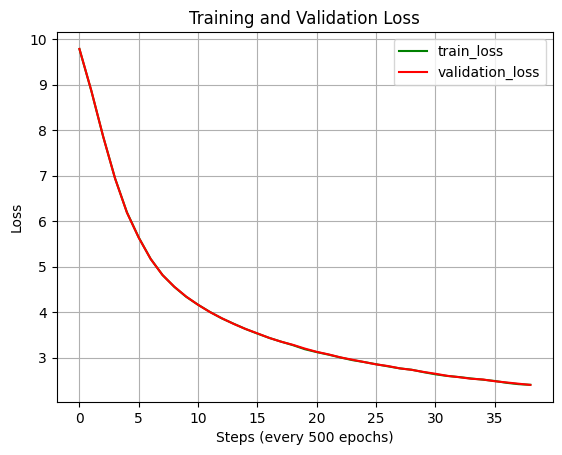

In [9]:
import matplotlib.pyplot as plt

# Check if lists are empty
if train_loss_list and validation_loss_list:
    train_loss_list_converted = [i.cpu().detach() if hasattr(i, 'cpu') else i for i in train_loss_list]
    validation_loss_list_converted = [i.cpu().detach() if hasattr(i, 'cpu') else i for i in validation_loss_list]

    plt.plot(train_loss_list_converted, 'g', label='train_loss')
    plt.plot(validation_loss_list_converted, 'r', label='validation_loss')
    plt.xlabel(f"Steps (every {eval_iters} epochs)")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")
    plt.grid(True)
    plt.show()
else:
    print("No loss data to plot. Did training run?")


## Graduation Day (Inference)

The training is done. Now for the fun part.

1. We create a *new*, un-trained `GPT` model with our `config`.
2. We `load_state_dict` to load the *saved weights* from our `best_model_params.pt` file.
3. We move the model to the GPU and, *critically*, call `model.eval()` to turn off dropout.
4. We create a starting `sentence`.
5. We `enc.encode_ordinary` it into tokens.
6. We call `model.generate()` to have it create 200 new tokens.
7. We `enc.decode()` the resulting list of tokens back into a human-readable story.

And just like that... we built a model that writes stories. Congratulations!

In [10]:
print("\nRunning inference with the best model...")
#Load the model
model = GPT(config)  # re-create the model with same config
# device = "cuda" if torch.cuda.is_available() else "cpu" # Already defined
best_model_params_path = "best_model_params.pt"

try:
    model.load_state_dict(torch.load(best_model_params_path, map_location=torch.device(device))) # load best model states
    model = model.to(device)
    model.eval() # Set model to evaluation mode
    print("Best model loaded successfully.")

    sentence = "Once upon a time there was a pumpkin."
    print(f"\n--- Prompt 1: '{sentence}' ---")
    context = (torch.tensor(enc.encode_ordinary(sentence), device=device).unsqueeze(dim = 0))
    y = model.generate(context, 200)
    print(enc.decode(y.squeeze().tolist()))

    sentence = "A little girl went to the woods"
    print(f"\n--- Prompt 2: '{sentence}' ---")
    context = (torch.tensor(enc.encode_ordinary(sentence), device=device).unsqueeze(dim = 0))
    y = model.generate(context, 200)
    print(enc.decode(y.squeeze().tolist()))

except FileNotFoundError:
    print(f"Error: Could not find the model file at {best_model_params_path}")
    print("Please ensure the model trained successfully and saved a checkpoint.")
except Exception as e:
    print(f"An error occurred during inference: {e}")


Running inference with the best model...
Best model loaded successfully.

--- Prompt 1: 'Once upon a time there was a pumpkin.' ---
Once upon a time there was a pumpkin. The plant looked good. He was upset; it belonged to hisding.

One day, the ant found a piece of ground. It had a big, hairy lime - it was painful, like a carrot! The ant froze and turned on the into a hole. Together, they dug as far as the worm played with theella!

The ant was scared, but nothing fallen apart from others. He pressed the stick and it fell and broke.emo and licked the worm with one. "You did not know how to be successful!" he said. From that day on, thevery always made sure to sweep the wormkingers.Once upon a time, there was a little girl named Lily. She loved to play outside with her friends. One day, she asked her mom what she was doing around her. Her mom said, "No, it's very hot and pain." But Lily was disappointed because she was Eventually, her mama helped her load herballs.

--- Prompt 2: 'A li

## My Analysis: What did we learn?

1. **It Learned English!** :  This is the most important part. It's not just spitting out random words. It learned subject-verb agreement ("He was upset," "The ant was scared"), punctuation (periods, commas, quotes!), and basic story structure (it starts with "Once upon a time..." and continues with "One day..."). This is a huge success.

2. **It's Coherent (Locally)**: On a sentence-by-sentence level, it makes some sense. "She looked for the gum in her mouth and her hand." is a grammatically valid (if weird) sentence. "The ant found a piece of ground" is a perfect sentence.

3. **It's an "Alien" Toddler**: This is the best way I can describe it. It has the vocabulary of a toddler (pumpkin, ant, carrot, girl, mom) but the logic of an alien.

      -  "it belonged to hisding." - "hisding" isn't a word. It's hallucinating.

      - "...a big, hairy lime - it was painful, like a carrot!" - This is amazing. It's associated "lime" and "carrot" (plants) but with "hairy" and "painful." This is a classic "small model" error. It knows words are associated, but not how.

      - "she was too igibrarian." - Another invented word. It probably mashed "big" and "librarian" or something similar.

      - "The pig couldn't wait to give Mama a big hug and two food." - "Two food" is so perfectly child-like and wrong.

      - "His ducks ends into the jungle..." - Grammar error (ends vs end or went).

4. **It Has No Long-Term Memory**: This is the key takeaway, and it's expected for a model this small with only a 128-token context window.

    - In Prompt 1, the story starts about a pumpkin. Then it becomes about an ant. Then a worm. Then Lily. It cannot hold a coherent plot. It just "drifts" from one associated topic to the next.

    - In Prompt 2, it's about a girl, then a spider, then a pigeon, then Sally, then a pig, then Hannah. It's just free-associating.



## Final Verdict:

This was a massive success! We built a model that genuinely learned the foundations of language from scratch. It's not coherent, but it's creative. The errors it makes aren't random; they are logical errors based on a limited understanding, which is fascinating.

To make it better, we'd need to go back to Step 5 and scale it up: more layers (`n_layer`), a wider embedding (`n_embd`), and a bigger context window (`block_size`). And, of course, a lot more training time.
